#### Libraries and dependencies

In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.signal import butter
from copy import deepcopy
from scipy.signal import filtfilt
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

In [2]:
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]
print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


In [3]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
lfp = session.get_lfp(1064735073)

In [15]:
chans = session.get_channels()
display(chans)

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,
1066253026,8409.0,3748.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7032.0,0,43,1064735071,20,APN
1066253027,8405.0,3740.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7033.0,1,11,1064735071,20,APN
1066253028,8402.0,3732.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7034.0,2,59,1064735071,40,APN
1066253029,8399.0,3723.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7036.0,3,27,1064735071,40,APN
1066253030,8396.0,3715.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7037.0,4,43,1064735071,60,APN
...,...,...,...,...,...,...,...,...,...
1066255415,6569.0,577.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,8905.0,379,27,1064735077,3800,root
1066255416,6565.0,570.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,8910.0,380,43,1064735077,3820,root
1066255417,6561.0,562.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,8915.0,381,11,1064735077,3820,root


In [12]:
print(lfp.channel.values)

[1066253838 1066253842 1066253846 1066253851 1066253855 1066253860
 1066253864 1066253868 1066253872 1066253876 1066253880 1066253884
 1066253888 1066253892 1066253896 1066253901 1066253905 1066253909
 1066253913 1066253918 1066253922 1066253927 1066253931 1066253935
 1066253939 1066253943 1066253947 1066253951 1066253955 1066253960
 1066253964 1066253968 1066253973 1066253978 1066253982 1066253986
 1066253990 1066253994 1066253998 1066254003 1066254007 1066254011
 1066254015 1066254019 1066254023 1066254027 1066254031 1066254036
 1066254040 1066254045 1066254049 1066254053 1066254057 1066254061
 1066254065 1066254069 1066254073 1066254077 1066254081 1066254085
 1066254089 1066254093 1066254097 1066254101 1066254105 1066254109
 1066254113 1066254118 1066254122 1066254126 1066254130 1066254134
 1066254138 1066254142 1066254146 1066254150 1066254154 1066254158
 1066254163 1066254167 1066254171 1066254176 1066254180 1066254184
 1066254188 1066254192 1066254196 1066254200 1066254204 106625

#### Tutorial

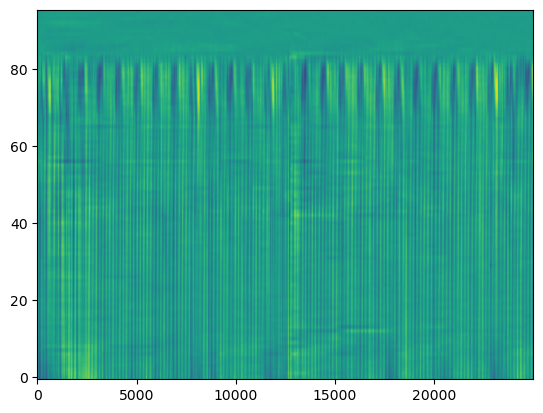

In [5]:
lfp_slice = lfp.sel(time=slice(100,120))
plt.imshow(lfp_slice.T, aspect='auto',origin='lower', cmap='viridis')

In [19]:
stim_presentations = session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

In [20]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [26]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)

Text(-0.4, 3570, 'brain surface')

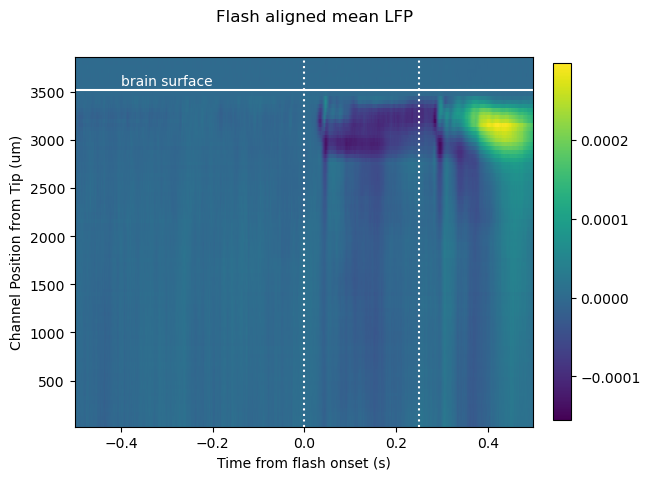

In [27]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

#### Filtering

In [4]:
lfp_slice = lfp.sel(time=slice(210,211))
lfp_copy = deepcopy(lfp_slice)

1250


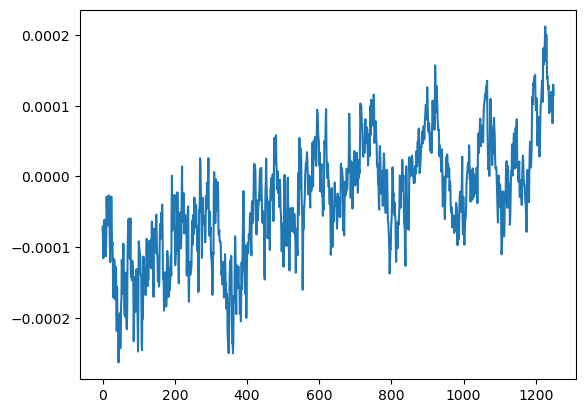

In [5]:
single = lfp_copy.T[0]
plt.plot(single)
print(len(single))

##### 3-8hz

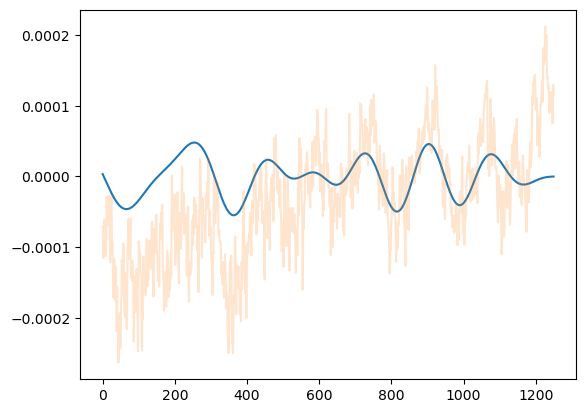

In [6]:
b,a = butter(N=3, Wn=[3, 8], fs=1250, btype='bandpass', output='ba')
y = filtfilt(b, a, single)
plt.plot(y)
plt.plot(single, alpha=0.2)

##### 10-30 Hz

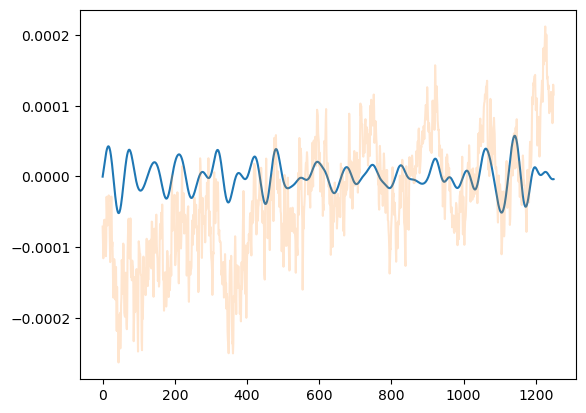

In [7]:
b,a = butter(N=3, Wn=[10, 30], fs=1250, btype='bandpass', output='ba')
y = filtfilt(b, a, single)
plt.plot(y)
plt.plot(single, alpha=0.2)

##### 30-50 Hz

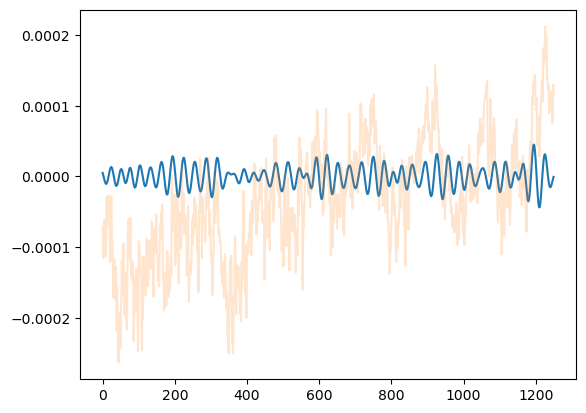

In [8]:
b,a = butter(N=3, Wn=[30, 50], fs=1250, btype='bandpass', output='ba')
y = filtfilt(b, a, single)
plt.plot(y)
plt.plot(single, alpha=0.2)

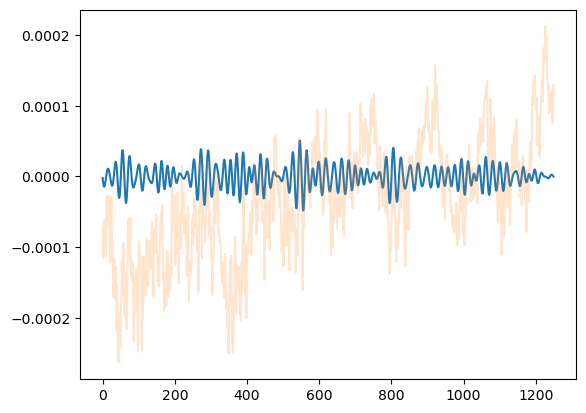

In [9]:
b,a = butter(N=3, Wn=[50, 80], fs=1250, btype='bandpass', output='ba')
y = filtfilt(b, a, single)
plt.plot(y)
plt.plot(single, alpha=0.2)